# Importing packages

In [1]:
import torch
import numpy as np
import lightning as L

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../transforms/')
sys.path.append('../TFC_Configs/')
sys.path.append('../models/')
sys.path.append('../data_modules/')
sys.path.append('../best_results/')

from config_files.TFC_Configs import *
from transforms.tfc_augmentations import *
from transforms.tfc_utils import set_seed, plot_model_metrics
from models.tfc import *
from data_modules.uci_4_tfc import *
from best_results.HAR.tfc_pretrain import *

In [4]:
set_seed(42)

In [5]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 22,
    'axes.linewidth': 2,
    'axes.titlesize': 24,
    'axes.edgecolor': 'black',
    'axes.labelsize': 24,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'font.family': 'Times New Roman',
    'legend.fontsize': 16,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})

# IMPORTANT INSTRUCTIONS

Inside the folder `models/tfc.py, class TFC_Backbone.` there will be a function called `compute_backbone_combined_loss`. Here, you must uncomment the print statements to visualize the loss . You must also comment the following line:

- loss_consistency = torch.clamp(loss_consistency, min=0.0)

Also note that the title of the notebooks has a number on it, i.e, 1,2,3. They help indicate the order in which these notebooks must be run

# 1.0 Loading Pretext Task DataLoader

In [6]:
# Configuration files that contains all hyperparameters to be used in the training (model, data, optimizer, loss, etc)

batch_size = 64
global_config_file = GlobalConfigFile(batch_size=batch_size) 

In [7]:
pretext_datamodule = build_pretext_datamodule(global_config_file=global_config_file, 
                                              batch_size=batch_size,
                                              root_data_dir='../data/uci/preprocessed/')

# 2.0 Understanding the Augmentations That Where Applied

In [8]:
example_module = UCIDataModule_4_TFC(root_data_dir='../data/uci/preprocessed/', # Data was preprocessed using the notebook/tf_c/1_ETL_UCI_WISDM, and then saved to this directory
                           batch_size=batch_size,
                           flatten=False,
                           target_column='class',
                           training_mode='TFC', # The specific transformations for TFC are done if this is set to 'TFC'
                           transform=False)     # No transformations for the example module

In [9]:
example_train_uci = example_module.train_dataloader()

loader_iter = iter(example_train_uci)
first_batch = next(iter(example_train_uci))

df, target = first_batch

We will sample unique classes to better visualize the differences. We have 6 batches with 6 sensors and 60 time steps. Each batch has a unique label

In [10]:
selected_data, unique_classes = sample_unique_classes(df, target)

print("Filtered Dataframe Shape:", selected_data.shape)
print("Unique Classes:", unique_classes)

Filtered Dataframe Shape: torch.Size([6, 6, 60])
Unique Classes: tensor([0, 1, 2, 3, 4, 5])


## 2.1 Time Augmentations

Each augmentation has their specific hyperparameters. For this study, we will use the default ones

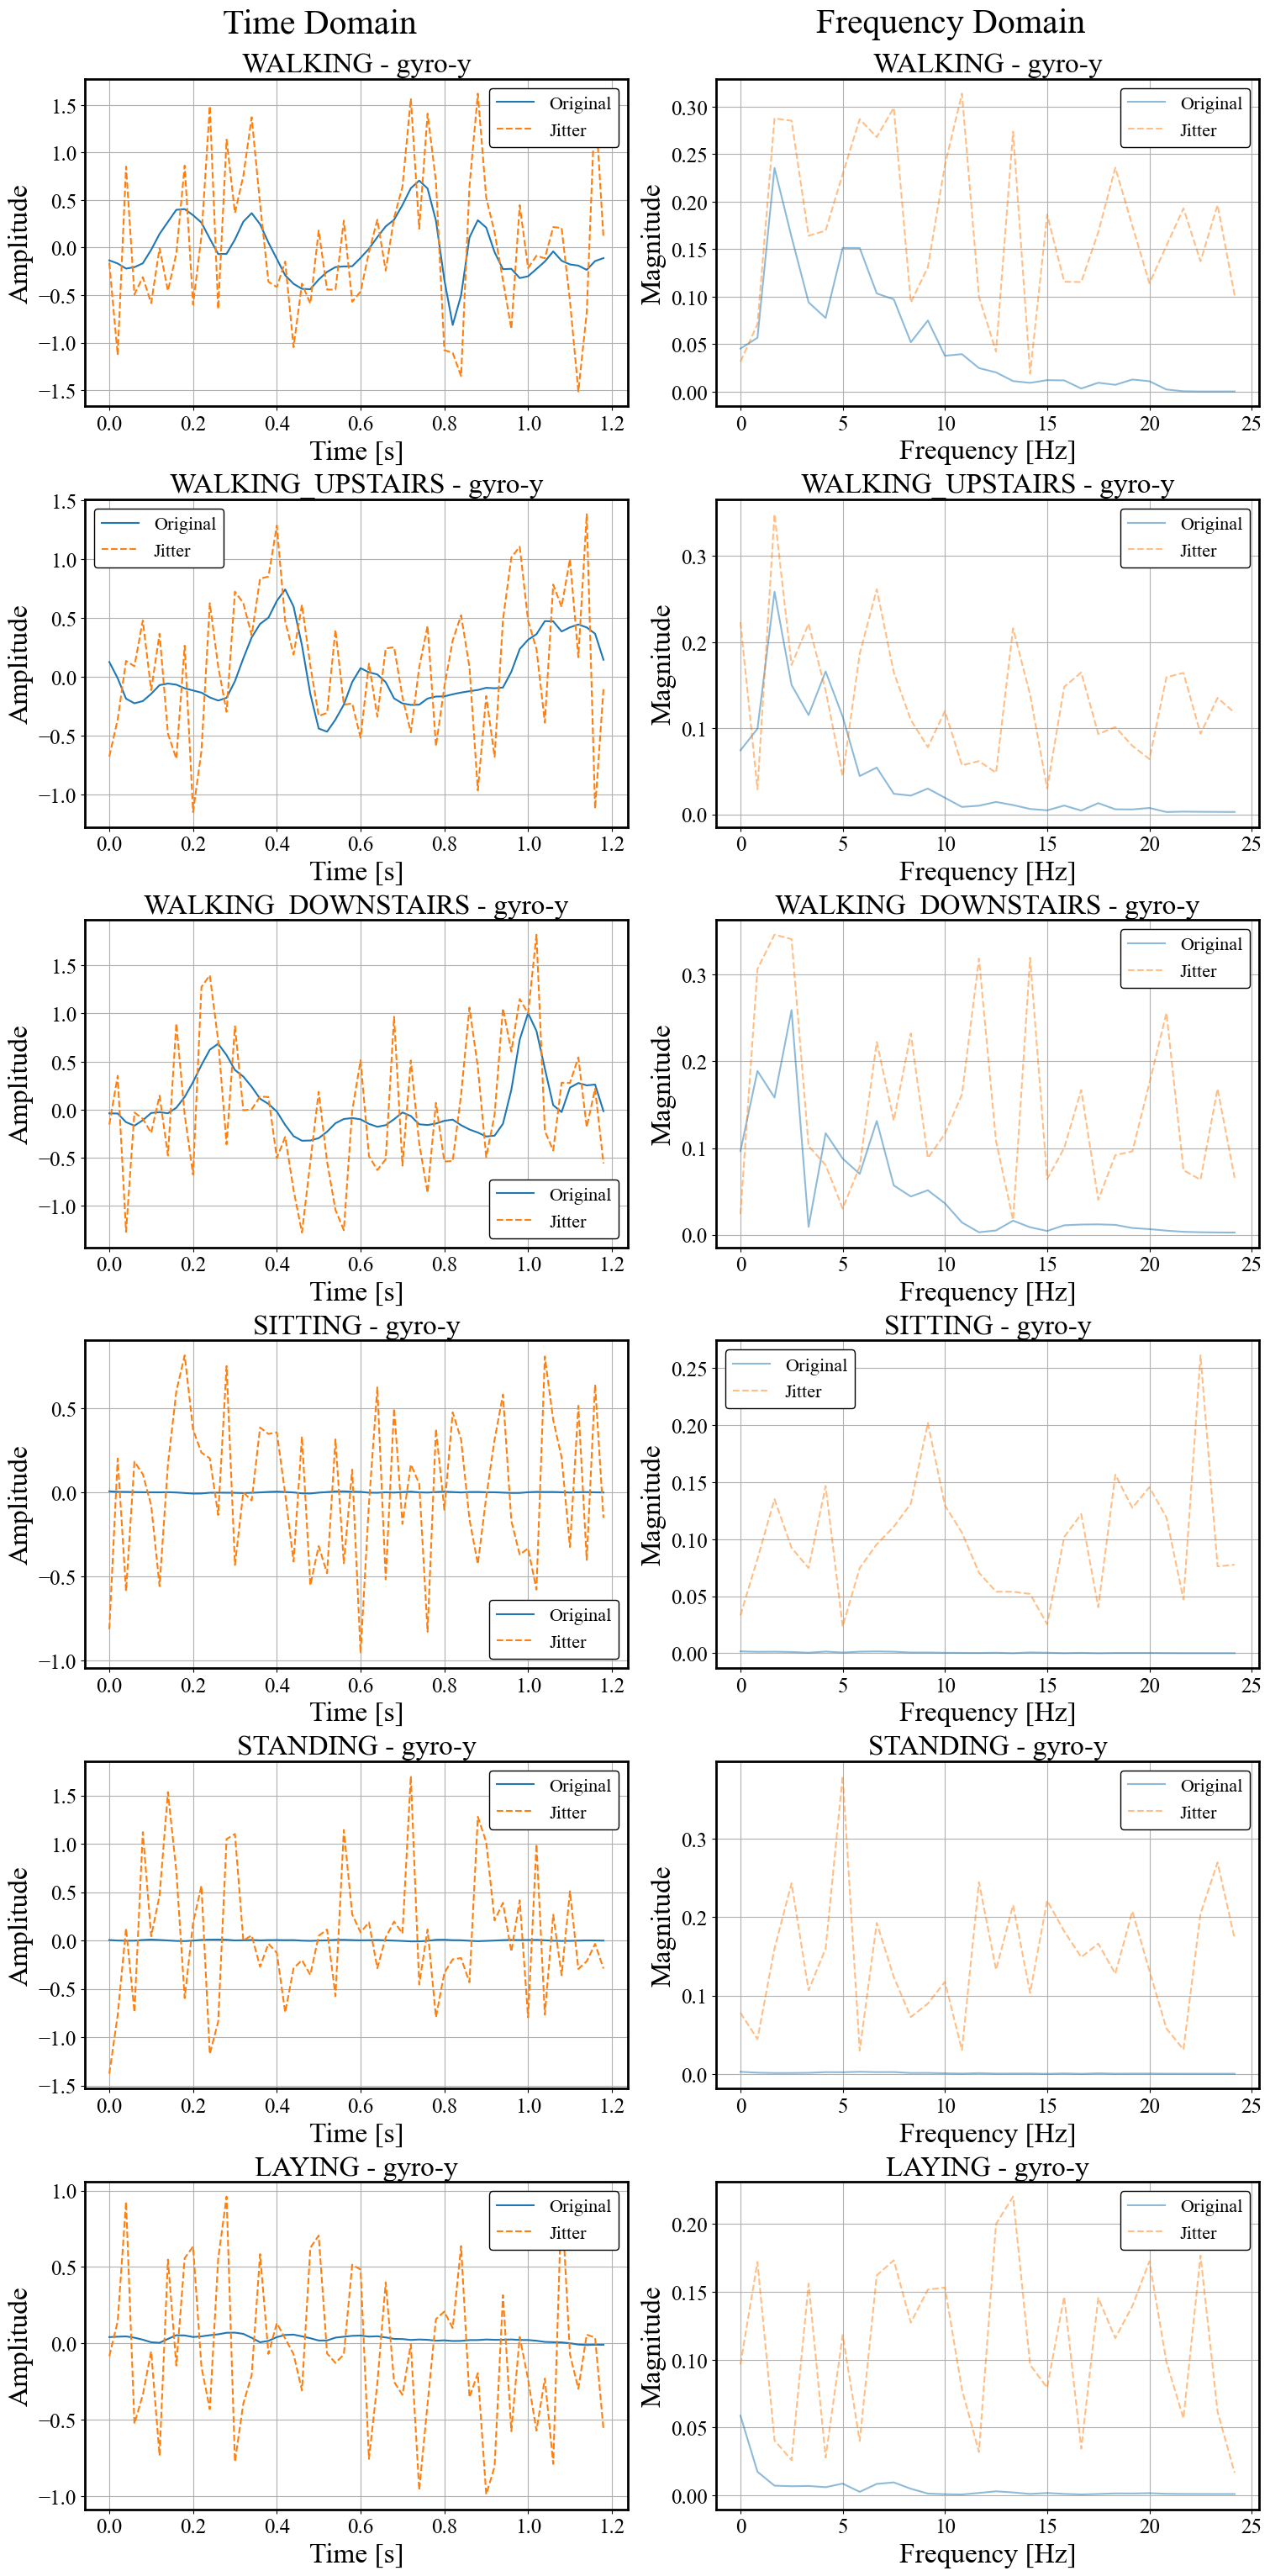

In [11]:
aug_time_and_plot_time_and_frequency_domain(data = selected_data, 
                               unique_classes=[1,2,3,4,5,6],
                               sensors = ['gyro-y'],
                               operation='jitter', # 'jitter', 'scaling', 'permutation', 'masking' 
                               )

## 2.2 Frequency Augmentations

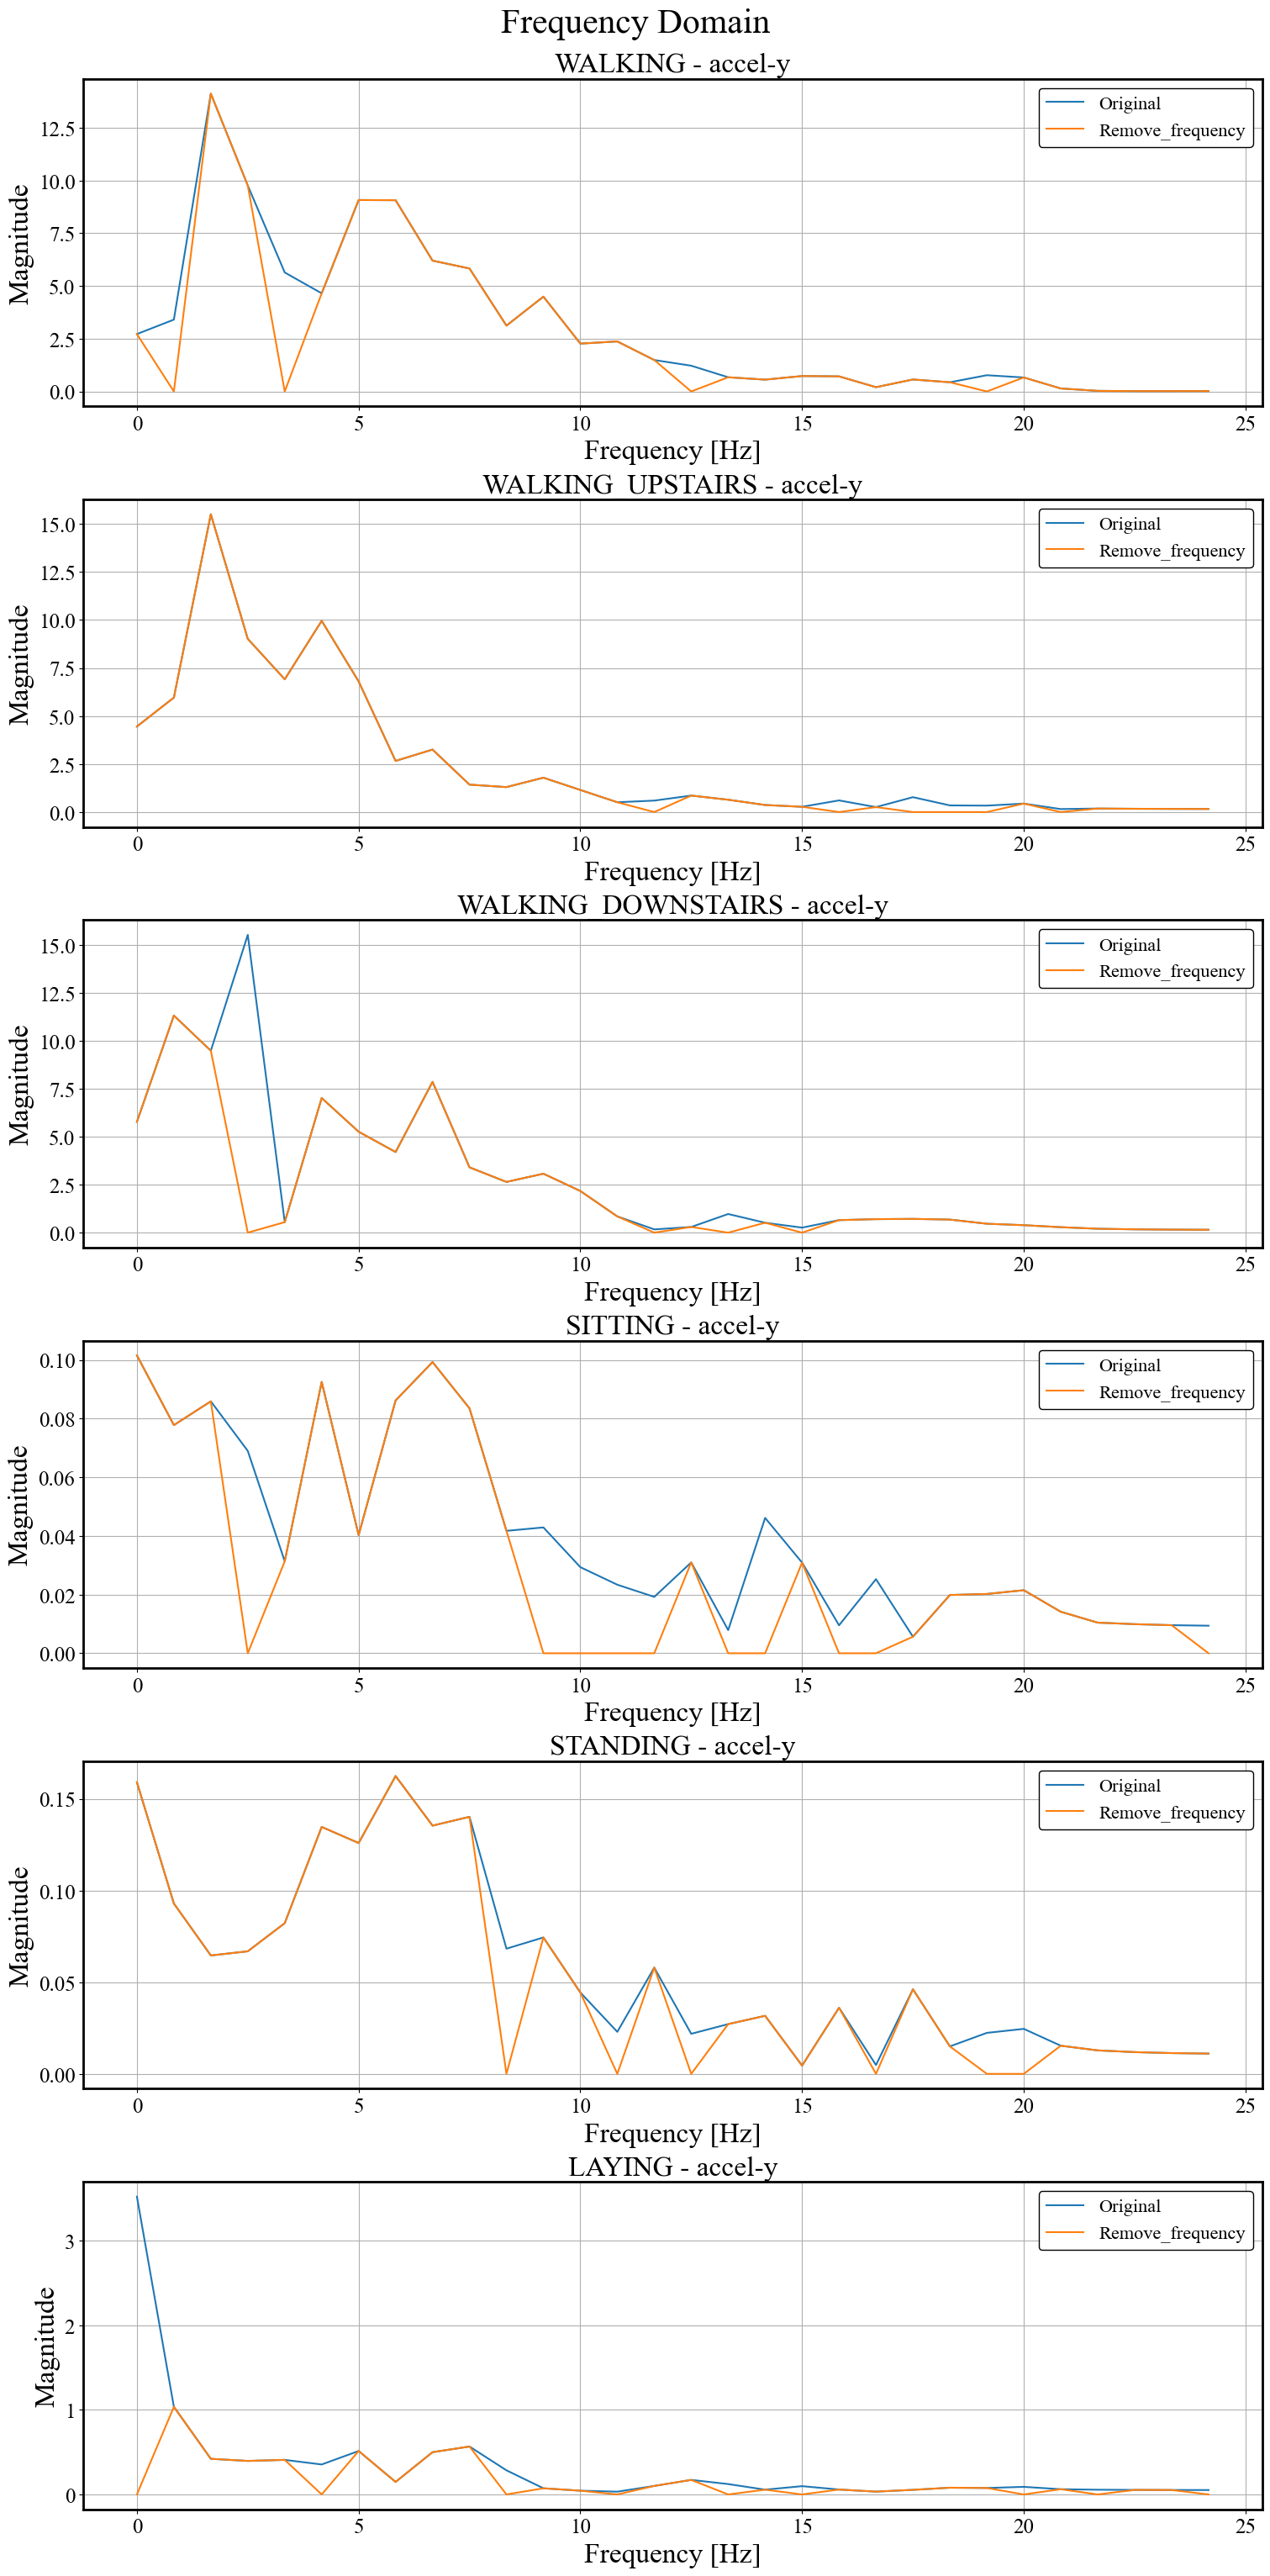

In [12]:
aug_freq_and_plot_freq_time_domain(data = selected_data, 
                               unique_classes=[1,2,3,4,5,6],
                               sensors = ['accel-y'],
                               operation='remove_frequency', # 'remove_frequency', 'add_frequency', 'both'
                               remove_ratio=0.2, # Hyperparameter for the operation
                               perturb_ratio=0.1, # Hyperparameter for the operation
                               )

# 3.0 Creating the Pretext Class Training Loop

Here we will train `ONLY` the Backbone without any label information. 

In [13]:
pretext_model = build_pretext_model(global_config_file)
SSL_technique_prefix = 'TF_C'

In [14]:
# Initializing parameters to name the experiment and the version
log_dir = "lightning_logs"
experiment_name = SSL_technique_prefix

pretext_lightning_trainer, experiment_path = build_lightning_trainer(log_dir=log_dir, 
                                                                 experiment_name=experiment_name, 
                                                                 verbose=True,
                                                                 version='Pretext',
                                                                 max_epochs=5, # High number of epochs so that the patience causes the stopping
                                                                 min_delta=0.005,
                                                                 patience=5,
                                                                 monitor='train_loss_total',
                                                                 SSL_technique_prefix=SSL_technique_prefix)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Fitting the model

In [15]:
pretext_lightning_trainer.fit(pretext_model, pretext_datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | nt_xent_criterion | NTXentLoss | 0     
1 | conv_block1_t     | Sequential | 1.6 K 
2 | conv_block2_t     | Sequential | 16.5 K
3 | conv_block3_t     | Sequential | 3.1 K 
4 | conv_block1_f     | Sequential | 1.6 K 
5 | conv_block2_f     | Sequential | 16.5 K
6 | conv_block3_f     | Sequential | 3.1 K 
7 | projector_t       | Sequential | 38.3 K
8 | projector_f       | Sequential | 38.3 K
-------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.476     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/193 [00:00<?, ?it/s] 
-------------------------
First Consistency Loss Term:
(S_T_F - S_T_Faug + constant):
10.29452133178711
-------------------------
Second Consistency Loss Term:
(S_T_F - S_Taug_F + constant):
11.207611083984375
-------------------------
Third Consistency Loss Term:
(S_T_F - S_Taug_Faug + constant):
11.79391098022461
-------------------------
Total Consistency Loss Term:
loss_consistency:
33.296043395996094
-------------------------

Epoch 0:   1%|          | 1/193 [00:03<10:07,  0.32it/s]
-------------------------
First Consistency Loss Term:
(S_T_F - S_T_Faug + constant):
10.19610595703125
-------------------------
Second Consistency Loss Term:
(S_T_F - S_Taug_F + constant):
10.289661407470703
-------------------------
Third Consistency Loss Term:
(S_T_F - S_Taug_Faug + constant):
10.260772705078125
-------------------------
Total Consistency Loss Term:
loss_consistency:
30.746540069580078
-------------------------

Epoch 0:   1%|      

Metric train_loss_total improved. New best score: -38092.645


Epoch 1:   0%|          | 0/193 [00:00<?, ?it/s, val_loss_total=-2.47e+5, val_loss_time_enc=9.230, val_loss_freq_enc=12.90, val_loss_consist=-3.08e+5, train_loss_total=-3.81e+4, train_loss_time_enc=13.90, train_loss_freq_enc=18.30, train_loss_consist=-4.76e+4]          
-------------------------
First Consistency Loss Term:
(S_T_F - S_T_Faug + constant):
-98066.0859375
-------------------------
Second Consistency Loss Term:
(S_T_F - S_Taug_F + constant):
-1754.9326171875
-------------------------
Third Consistency Loss Term:
(S_T_F - S_Taug_Faug + constant):
-102898.4296875
-------------------------
Total Consistency Loss Term:
loss_consistency:
-202719.4375
-------------------------

Epoch 1:   1%|          | 1/193 [00:00<01:41,  1.90it/s, val_loss_total=-2.47e+5, val_loss_time_enc=9.230, val_loss_freq_enc=12.90, val_loss_consist=-3.08e+5, train_loss_total=-3.81e+4, train_loss_time_enc=13.90, train_loss_freq_enc=18.30, train_loss_consist=-4.76e+4]
-------------------------
First Consi

Based on the print statements above, the cross-space term is responsible for the divergance. In the notebook `TF_C_2_pretext_task_with_floor`, we floor the cross_space term to be 0 for the training set, while keeping it for the validation set. This will stop the negative values in the training set, but we will still be able to observe this term's effect on the validation loss 

Tune in to the next notebook to see what happened